In [1]:
import copy
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def calculate_daily_return(row):
    return row['Close'] - row['Open']

In [3]:
def expected_value(values):
    return statistics.mean(values)

In [5]:
def confidence_interval(data, confidence=0.95):
    dist = statistics.NormalDist.from_samples(data)
    z = statistics.NormalDist().inv_cdf((1 + confidence) / 2.)
    h = dist.stdev * z / ((len(data) - 1) ** .5)
    return dist.mean - h, dist.mean + h

In [6]:
def load_stock(filename):
    data = pd.read_csv('../yahoo/{}'.format(filename))
    data['Gross Return'] = data.apply(calculate_daily_return, axis=1)
    data['Pct Return'] = data.apply(lambda row: 100*row['Gross Return']/row['Open'], axis=1)
    return data

In [7]:
nasdaq = load_stock('NASDAQ_10y.csv')
nasdaq.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Gross Return,Pct Return
0,2010-09-07,2227.260010,2231.280029,2206.620117,2208.889893,2208.889893,1685240000,-18.370117,-0.824785
1,2010-09-08,2216.070068,2237.419922,2215.899902,2228.870117,2228.870117,2018210000,12.800049,0.577601
2,2010-09-09,2251.090088,2251.979980,2229.800049,2236.199951,2236.199951,1706650000,-14.890137,-0.661463
3,2010-09-10,2239.080078,2246.600098,2229.120117,2242.479980,2242.479980,1692470000,3.399902,0.151844
4,2010-09-13,2263.800049,2289.489990,2263.689941,2285.709961,2285.709961,1937630000,21.909912,0.967838


In [9]:
def get_composite_var(composite):
    return composite.var()

def calc_cov(comp, stock, metric):
#     cov_data = pd.DataFrame()
    dates = list(stock['Date'])
    cov_data = pd.DataFrame({'Date': dates,
                            'Comp Met': [comp.iloc[i][metric] for i in range(len(comp.index)) if comp.iloc[i]['Date'] in dates],
                            'Stock Met': [stock.iloc[i][metric] for i in range(len(stock.index))]})
#     cov_data['Comp Metric'] = cov_data.apply(lambda row: comp[comp['Date'] == row[1][0]][metric])
#     cov_data['Stock Metric'] = cov_data.apply(lambda row: stock[stock['Date'] == row[1][0]][metric])
#     for row in stock.iterrows():
#         comp_row = comp.loc[comp['Date']==row['Date']]
#         print(comp_row)
#         comp_met = comp[metric]
#         stock_met = row[metric]
#         cov_data.append([row['Date'], comp_met, stock_met])
#     cov_data.columns = ['Date', 'Comp Met', 'Stock Met']
#     print(cov_data.head())
    return cov_data['Stock Met'].cov(cov_data['Comp Met'])

def calc_B_im(stock, comp, metric, comp_var=None, cov=None):
    if comp_var[metric] == None:
        comp_var = get_composite_var(comp)
    if cov == None:
        cov = calc_cov(comp, stock, metric)
    return cov/comp_var[metric]

In [10]:
costco = load_stock('COST_10y.csv')
costco.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Gross Return,Pct Return
0,2010-09-07,58.250000,59.000000,58.200001,58.639999,45.681999,2598500,0.389999,0.669526
1,2010-09-08,59.369999,59.419998,58.799999,59.209999,46.126049,3412700,-0.160000,-0.269496
2,2010-09-09,59.500000,59.509998,58.830002,58.939999,45.915714,2622900,-0.560001,-0.941178
3,2010-09-10,59.299999,59.790001,59.139999,59.540001,46.383121,2608600,0.240002,0.404725
4,2010-09-13,59.820000,60.230000,59.410000,60.049999,46.780426,3107800,0.229999,0.384485


In [11]:
stockList = ['COST', 'INTC', 'AAPL', 'TSLA'] # must download data first
compName = 'NASDAQ'

In [12]:
comp = load_stock('{}_10y.csv'.format(compName))
comp_var = get_composite_var(comp)

stocks = pd.DataFrame({'B_im': [0 for n in range(len(stockList))],
                       'cov': [0 for n in range(len(stockList))]}, index=stockList)

In [13]:
for stock in stockList:
    stock_data = load_stock('{}_10y.csv'.format(stock))
    c = calc_cov(comp, stock_data, 'Pct Return')
    stocks.loc[stock, 'cov'] = c
    stocks.loc[stock, 'B_im'] = calc_B_im(stock_data, comp, 'Pct Return', comp_var=comp_var, cov=c)

0.4534053195775454
0.76623022495661
0.8417945343211959
1.07379490147016


In [15]:
daily_data = pd.DataFrame({'Comp Return' : comp['Pct Return']})
for stock in stockList:
    stock_data = load_stock('{}_10y.csv'.format(stock))
    daily_data['{} Return'.format(stock)] = stock_data['Pct Return']
daily_data.head()

,Comp Return,COST Return,INTC Return,AAPL Return,TSLA Return
0,-0.824785,0.669526,-1.307189,0.455895,-0.339641
1,0.577601,-0.269496,-0.776059,1.208717,1.161665
2,-0.661463,-0.941178,-0.277003,-0.743283,-1.380952
3,0.151844,0.404725,0.111409,0.083588,-2.795181
4,0.967838,0.384485,1.866081,0.458963,-0.813787


In [16]:
R_om = min([abs(c) for c in stocks['cov']])
R_om = pd.Series([min(list(row)) for index, row in daily_data.iterrows()])
R_om

0      -1.307189
1      -0.776059
2      -1.380952
3      -2.795181
4      -0.813787
          ...   
2513   -0.098037
2514   -5.394915
2515   -6.601390
2516   -4.751404
2517   -2.093340
Length: 2518, dtype: float64

In [17]:
def calc_E_rm(series, mult_columns=True):
    if mult_columns:
        t = np.trapz(series['Pct Return'])/len(series.index)
    else:
        t = np.trapz(series)/len(series.index)
    return t
calc_E_rm(comp)

0.032708829851526414

In [18]:
def get_a_im(R_om, stocks, stocklist):
    expected_R_om = calc_E_rm(R_om, mult_columns=False)
    a_ims = []
    for stockName in stockList:
        parentheses = float(1.0 - stocks['B_im'][stockName])
        a_ims.append(expected_R_om * parentheses)
    stocks['a_im'] = a_ims
    return stocks

In [19]:
stocks = get_a_im(R_om, stocks, stockList)
stocks

,B_im,cov,a_im
COST,0.547323,0.453405,-0.607848
INTC,0.924947,0.766230,-0.100781
AAPL,1.016163,0.841795,0.021704
TSLA,1.296220,1.073795,0.397761


In [ ]:
def weighted_portfolio(stocks, weights=[]):
    if len(weights) != len(stocks.index):
        weights = [1/len(stocks.index) for i in range(stocks.index)]
    portfolio = copy.copy(stocks)
    portfolio.append()

In [34]:
regression = pd.DataFrame({'Date': copy.copy(comp['Date']),
                           'R_m': copy.copy(comp['Pct Return'])})
for stock in stocks.index:
    regression['R_i {}'.format(stock)] = regression.apply(lambda row: stocks.loc[stock, 'B_im']*row['R_m'] + stocks.loc[stock, 'a_im'], axis=1)
    regression['True {}'.format(stock)] = copy.copy(load_stock('{}_10y.csv'.format(stock))['Pct Return'])
regression

,Date,R_m,R_i COST,True COST,R_i INTC,True INTC,R_i AAPL,True AAPL,R_i TSLA,True TSLA
0,2010-09-07,-0.824785,-1.059273,0.669526,-0.863663,-1.307189,-0.816413,0.455895,-0.671343,-0.339641
1,2010-09-08,0.577601,-0.291714,-0.269496,0.433470,-0.776059,0.608641,1.208717,1.146459,1.161665
2,2010-09-09,-0.661463,-0.969883,-0.941178,-0.712599,-0.277003,-0.650451,-0.743283,-0.459641,-1.380952
3,2010-09-10,0.151844,-0.524741,0.404725,0.039667,0.111409,0.176002,0.083588,0.594584,-2.795181
4,2010-09-13,0.967838,-0.078128,0.384485,0.794418,1.866081,1.005185,0.458963,1.652292,-0.813787
...,...,...,...,...,...,...,...,...,...,...
2513,2020-08-31,0.483414,-0.343265,0.233530,0.346352,-0.098037,0.512932,1.144373,1.024372,12.080255
2514,2020-09-01,0.748547,-0.198151,1.640107,0.591585,-0.235708,0.782350,1.069598,1.368042,-5.394915
2515,2020-09-02,0.076205,-0.566139,1.484687,-0.030295,2.030855,0.099141,-4.498875,0.496540,-6.601390
2516,2020-09-03,-3.404183,-2.471038,-4.068091,-3.249468,-4.019050,-3.437502,-4.751404,-4.014810,-0.056482


In [78]:
def plot_reg(stocks, regression):
    plt.figure(figsize=(15, 10))
    axes = plt.gca()
    axes.set_xlabel('R_m: market return')
    axes.set_ylabel('R_i for all i: regressed return per stock')
    r2_list = []
    for stock in stocks.index:
        plt.plot(regression['R_m'], regression['R_i {}'.format(stock)], label='{} reg'.format(stock))
        plt.scatter(list(regression['R_m'])[::10], list(regression['True {}'.format(stock)])[::10], label='{} values'.format(stock))
        
        correlation_matrix = np.corrcoef(regression['R_i {}'.format(stock)], regression['True {}'.format(stock)])
        correlation_xy = correlation_matrix[0,1]
        r_squared = correlation_xy**2
        r2_list.append(r_squared)
    plt.legend()
    plt.title('CAPM Regression compared to NASDAQ composite')
    plt.show()
    return r2_list

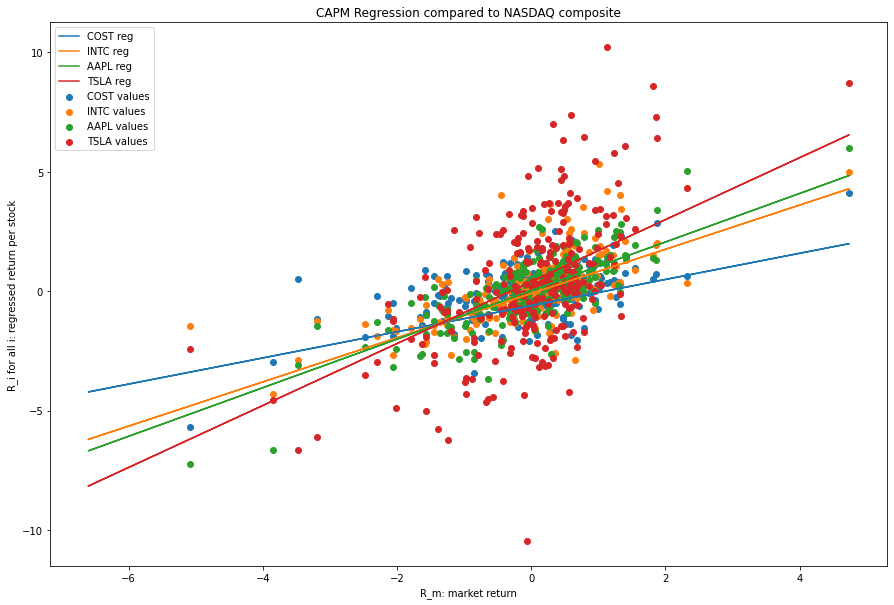

In [79]:
r2 = plot_reg(stocks, regression)

In [ ]:
## https://www.kite.com/python/answers/how-to-calculate-r-squared-with-numpy-in-python

x_values = [1,2,3]
y_values = [1,5,25]

correlation_matrix = np.corrcoef(x_values, y_values)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

print(r_squared)

In [68]:
zero_int = confidence_interval(list(nasdaq['Pct Return']))
zero_int

(-0.003156899863176209, 0.06795753314186687)

In [69]:
stocks['a_im']

COST   -0.607848
INTC   -0.100781
AAPL    0.021704
TSLA    0.397761
Name: a_im, dtype: float64

In [31]:
stocks['Zero intercept (95% conf)'] = stocks.apply(lambda row: (row['a_im']>zero_int[0] and row['a_im']<zero_int[1]), axis=1)
stocks

,B_im,cov,a_im,Zero intercept,Zero intercept (95% confidence),Zero intercept (95% conf)
COST,0.547323,0.453405,-0.607848,False,False,False
INTC,0.924947,0.766230,-0.100781,False,False,False
AAPL,1.016163,0.841795,0.021704,True,True,True
TSLA,1.296220,1.073795,0.397761,False,False,False
